<a href="https://colab.research.google.com/github/montben/ContentModAPI/blob/main/notebooks/simplified_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplified Content Moderation Training

This notebook trains a BERT model using a **single comprehensive dataset** (Civil Comments).

**🚀 Best run on Google Colab for free GPU!**

## What Changed?
- ✅ **ONE dataset** instead of 5+ mixed datasets
- ✅ **6 labels** instead of 8 (removed self_harm and spam)
- ✅ **Consistent labeling** from a single source
- ✅ **Better training** with cleaner data

## Labels:
1. Toxicity - General toxic language
2. Hate Speech - Identity-based attacks
3. Harassment - Personal attacks
4. Violence - Threats and violent content
5. Sexual - Sexual content
6. Profanity - Explicit language

---

## ⚙️ Colab Setup Instructions

1. **Enable GPU**: Runtime → Change runtime type → Hardware accelerator → GPU
2. **Run all cells** in order
3. Training will take ~30-45 minutes with GPU


In [1]:
# ====================================
# STEP 0: Clone Repository (Colab Only)
# ====================================
# Run this cell if you're on Colab

import os
import sys

# Check if we're in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔵 Running on Google Colab")

    # Clone the repository if not already cloned
    if not os.path.exists('/content/ContentModAPI'):
        print("📥 Cloning repository...")
        !git clone https://github.com/montben/ContentModAPI.git /content/ContentModAPI
        print("✅ Repository cloned!")
    else:
        print("✅ Repository already cloned!")

    # Change to project directory
    os.chdir('/content/ContentModAPI')
    print(f"📁 Working directory: {os.getcwd()}")

    # Install dependencies
    print("\n📦 Installing dependencies...")
    !pip install -q transformers datasets torch scikit-learn pandas numpy matplotlib seaborn
    print("✅ Dependencies installed!")
else:
    print("🟢 Running locally")

# Check GPU
import torch
print(f"\n🚀 GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU device: {torch.cuda.get_device_name(0)}")
else:
    print("   ⚠️  No GPU detected. Training will be slow.")
    print("   💡 In Colab: Runtime → Change runtime type → GPU")


🔵 Running on Google Colab
✅ Repository already cloned!
📁 Working directory: /content/ContentModAPI

📦 Installing dependencies...
✅ Dependencies installed!

🚀 GPU available: True
   GPU device: Tesla T4


In [2]:
# ====================================
# STEP 1: Import Libraries
# ====================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Add project to path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("✅ All imports loaded!")
print(f"📁 Working from: {os.getcwd()}")


✅ All imports loaded!
📁 Working from: /content/ContentModAPI


In [3]:
# Delete old cached data
!rm -rf data/datasets/civil_comments
print("✅ Old data deleted, will re-download fresh")

✅ Old data deleted, will re-download fresh


## Step 2: Download Dataset

Download Civil Comments dataset from HuggingFace (~5-10 minutes for full dataset).

**Options:**
- `sample_size=10000` - Quick test (recommended for first run)
- `sample_size=None` - Full dataset (~300k samples, best results)


In [4]:
# ====================================
# STEP 2: Download Civil Comments Dataset
# ====================================

from scripts.data_collection.download_civil_comments import download_civil_comments

# Check if already downloaded
dataset_path = Path("data/datasets/civil_comments/processed_data.csv")

if not dataset_path.exists():
    print("📥 Downloading Civil Comments dataset from HuggingFace...")
    print("This will take ~5-10 minutes depending on sample size...")
    print()

    # Download dataset
    # Use sample_size=10000 for quick test, None for full dataset
    download_civil_comments(
        output_dir="data/datasets",
        sample_size=100000  # Change to None for full 300k dataset
    )
    print("\n✅ Download complete!")
else:
    print("✅ Dataset already downloaded!")

# Show what we have
if dataset_path.exists():
    df_check = pd.read_csv(dataset_path)
    print(f"\n📊 Dataset ready: {len(df_check):,} samples")
    del df_check


📥 Downloading Civil Comments dataset from HuggingFace...
This will take ~5-10 minutes depending on sample size...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



✅ Download complete!

📊 Dataset ready: 100,000 samples


## Step 3: Load and Explore Data


In [5]:
# Load the dataset
df = pd.read_csv("data/datasets/civil_comments/processed_data.csv")

print(f"📊 Dataset size: {len(df):,} samples")
print(f"\n📋 Columns: {list(df.columns)}")
print(f"\n🔍 First few rows:")
df.head()


📊 Dataset size: 100,000 samples

📋 Columns: ['text', 'source', 'original_id', 'toxicity', 'hate_speech', 'harassment', 'violence', 'sexual', 'profanity', 'label_vector']

🔍 First few rows:


,text,source,original_id,toxicity,hate_speech,harassment,violence,sexual,profanity,label_vector
0,What a breathe of fresh air to have someone wh...,civil_comments,sample_0,False,False,False,False,False,False,"0,0,0,0,0,0"
1,Your jewish friends were the ones who told you...,civil_comments,sample_1,True,True,True,False,False,False,"1,1,1,0,0,0"
2,Possible collusion by Trump and his affiliates...,civil_comments,sample_2,False,False,False,False,False,False,"0,0,0,0,0,0"
3,Exactly. We need a % of GDP spending cap at t...,civil_comments,sample_3,False,False,False,False,False,False,"0,0,0,0,0,0"
4,"By your own comment, even if some of them vote...",civil_comments,sample_4,False,False,False,False,False,False,"0,0,0,0,0,0"


📊 Label Distribution:
  toxicity: 7,938 (7.94%)
  hate_speech: 769 (0.77%)
  harassment: 6,343 (6.34%)
  violence: 239 (0.24%)
  sexual: 676 (0.68%)
  profanity: 520 (0.52%)


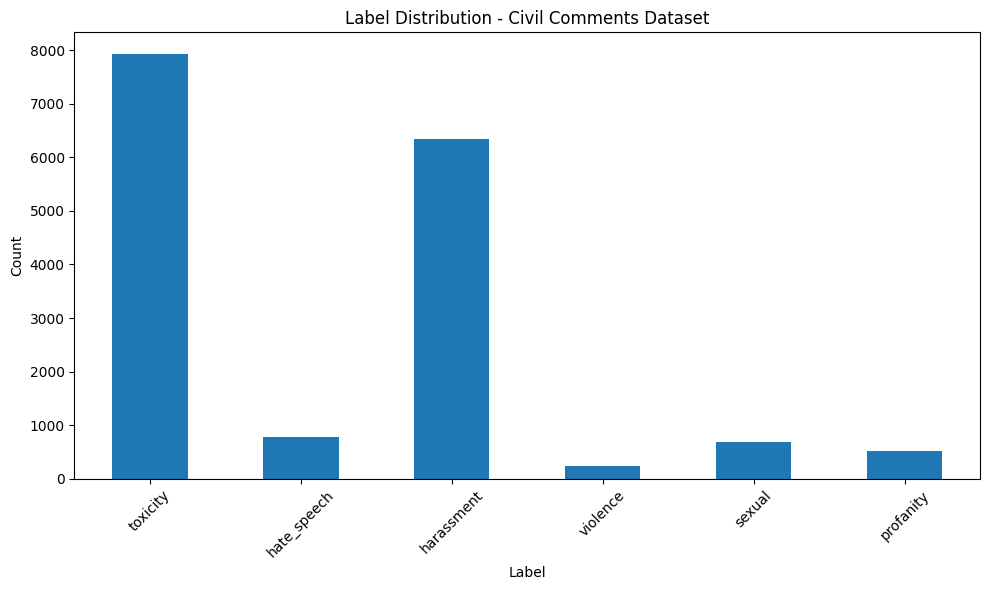

In [6]:
# Label distribution
from scripts.preprocessing.label_schema import LABEL_SCHEMA
import matplotlib.pyplot as plt

label_columns = list(LABEL_SCHEMA.keys())
label_counts = df[label_columns].sum()

print("📊 Label Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count:,} ({percentage:.2f}%)")

# Visualize
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution - Civil Comments Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 3: Train Model

Use the training script to train BERT on this single dataset.


## Step 4: Create Train/Val/Test Splits


In [7]:
# ====================================
# STEP 4: Create Data Splits
# ====================================

from sklearn.model_selection import train_test_split

# Create splits: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Add split column
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine back
final_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"📈 Data Split:")
print(f"  Train: {len(train_df):6,} samples ({len(train_df)/len(final_df)*100:.1f}%)")
print(f"  Val:   {len(val_df):6,} samples ({len(val_df)/len(final_df)*100:.1f}%)")
print(f"  Test:  {len(test_df):6,} samples ({len(test_df)/len(final_df)*100:.1f}%)")

# Save to disk
output_file = "data/datasets/civil_comments_with_splits.csv"
final_df.to_csv(output_file, index=False)
print(f"\n💾 Saved split dataset to: {output_file}")


📈 Data Split:
  Train: 80,000 samples (80.0%)
  Val:   10,000 samples (10.0%)
  Test:  10,000 samples (10.0%)

💾 Saved split dataset to: data/datasets/civil_comments_with_splits.csv


## Step 5: Train BERT Model

Now we'll train the BERT model on our dataset. This will take ~30-45 minutes with GPU.


In [8]:
# ====================================
# STEP 5: Train BERT Model
# ====================================

from scripts.training.train_bert import MultiLabelTrainer

# Initialize trainer
print("🤖 Initializing BERT model...")
trainer = MultiLabelTrainer(
    model_name="bert-base-uncased",
    num_labels=6  # Our 6-label schema
)

# Load model
trainer.load_model()
print("✅ Model loaded!")
print(f"   Model: {trainer.model_name}")
print(f"   Labels: {trainer.num_labels}")
print(f"   Parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")


🤖 Initializing BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded!
   Model: bert-base-uncased
   Labels: 6
   Parameters: 109,486,854


In [9]:
# Prepare dataset for training
print("📊 Preparing dataset...")
dataset = trainer.prepare_dataset(output_file)
print("✅ Dataset prepared!")

print(f"\nDataset splits:")
for split, data in dataset.items():
    print(f"  {split:12} {len(data):6,} samples")


📊 Preparing dataset...


/content/ContentModAPI/scripts/training/train_bert.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['text'] = df_subset['text'].fillna('').astype(str)
/content/ContentModAPI/scripts/training/train_bert.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['text'] = df_subset['text'].fillna('').astype(str)
/content/ContentModAPI/scripts/training/train_bert.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

✅ Dataset prepared!

Dataset splits:
  train        80,000 samples
  validation   10,000 samples
  test         10,000 samples


In [ ]:
# Training configuration
config = {
    'epochs': 2,  # Start with 2 epochs for testing
    'batch_size': 16,  # Reduce to 8 if you run out of GPU memory
    'eval_batch_size': 32,
    'learning_rate': 2e-5,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'use_wandb': False  # Set to True if you want experiment tracking
}

output_dir = "artifacts/models/bert-multilabel"

print("🏋️ Starting training...")
print(f"Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")
print(f"\nOutput directory: {output_dir}")
print("\n⏰ This will take ~30-45 minutes with GPU...")
print("☕ Grab some coffee!\n")

# Train the model
trained_model = trainer.train(dataset, output_dir, config)

print("\n✅ Training complete!")


🏋️ Starting training...
Configuration:
  epochs: 2
  batch_size: 16
  eval_batch_size: 32
  learning_rate: 2e-05
  warmup_steps: 500
  weight_decay: 0.01
  use_wandb: False

Output directory: artifacts/models/bert-multilabel

⏰ This will take ~30-45 minutes with GPU...
☕ Grab some coffee!



wandb: Currently logged in as: montben (montben-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,F1 Weighted,F1 Toxicity,F1 Hate Speech,F1 Harassment,F1 Violence,F1 Sexual,F1 Profanity
500,0.105100,0.083283,0.146289,0.393123,0.380037,0.399619,0.000000,0.478114,0.000000,0.000000,0.000000
1000,0.061800,0.074413,0.155025,0.421384,0.407000,0.467087,0.000000,0.463065,0.000000,0.000000,0.000000
1500,0.071100,0.059514,0.210761,0.570504,0.540494,0.624213,0.000000,0.607018,0.000000,0.033333,0.000000
2000,0.066400,0.059106,0.314437,0.583442,0.560346,0.615182,0.000000,0.620900,0.000000,0.329114,0.321429
2500,0.051500,0.067136,0.284679,0.422923,0.415868,0.443636,0.000000,0.451178,0.000000,0.395349,0.417910
3000,0.053200,0.056923,0.383421,0.605309,0.594919,0.642706,0.173077,0.638912,0.000000,0.395833,0.450000
3500,0.048800,0.053419,0.388448,0.594748,0.585330,0.629630,0.213592,0.624329,0.000000,0.395604,0.467532
4000,0.055400,0.051902,0.331723,0.610028,0.590103,0.652262,0.045977,0.645669,0.000000,0.325000,0.321429
4500,0.055300,0.051863,0.318787,0.583796,0.566922,0.620337,0.130435,0.624772,0.000000,0.235294,0.301887


## Step 6: Evaluate Model

Let's see how well our model performed!


In [ ]:
# ====================================
# STEP 6: Evaluate Model
# ====================================

print("📊 Evaluating on test set...")
test_results = trained_model.evaluate(dataset['test'])

print("\n📈 Test Results:")
print("="*60)

# Show F1 scores
f1_metrics = {k: v for k, v in test_results.items() if 'f1' in k}
for metric, value in sorted(f1_metrics.items()):
    metric_name = metric.replace('eval_', '')
    stars = "⭐" * int(value * 5)  # Visual rating
    print(f"{metric_name:20} {value:.4f} {stars}")

# Save results
import json
results_path = Path(output_dir) / "test_results.json"
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"\n💾 Results saved to: {results_path}")


## Step 7: Test the Model

Try the model on some example texts!


In [ ]:
# ====================================
# STEP 7: Test the Model
# ====================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load trained model
print("📦 Loading trained model...")
model = AutoModelForSequenceClassification.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"✅ Model loaded on: {device}")

def predict(text):
    """Predict labels for a given text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.sigmoid(outputs.logits)

    # Get predictions
    results = {}
    for i, label in enumerate(LABEL_SCHEMA.keys()):
        prob = predictions[0][i].item()
        results[label] = {
            'probability': prob,
            'flagged': prob > 0.5
        }

    return results

# Test examples
test_texts = [
    "I love this community, everyone is so helpful and kind!",
    "You're a complete idiot and should just shut up",
    "I disagree with your opinion but respect your viewpoint",
    "This is absolute garbage and you're an incompetent moron",
]

print("\n🧪 Testing model on example texts:\n")
print("="*70)

for i, text in enumerate(test_texts, 1):
    print(f"\n📝 Example {i}:")
    print(f"   Text: \"{text}\"")
    results = predict(text)

    flagged_labels = [label for label, info in results.items() if info['flagged']]

    if flagged_labels:
        print(f"   ⚠️  FLAGGED: {', '.join(flagged_labels)}")
        for label in flagged_labels:
            print(f"      - {label}: {results[label]['probability']:.3f}")
    else:
        print(f"   ✅ SAFE (no flags)")

print("\n" + "="*70)


In [ ]:
# For full training, use the command line:
# python scripts/training/train_bert.py --data-path data/datasets/civil_comments/processed_data.csv

print("✅ Training simplified!")
print("\nTo train the model, run:")
print("  python scripts/training/train_bert.py \\")
print("    --data-path data/datasets/civil_comments/processed_data.csv \\")
print("    --epochs 3 \\")
print("    --batch-size 16")
print("\nThis will train a BERT model on the Civil Comments dataset.")
